In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [12]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [38]:
noprior_vals = print_validation_profile_and_prior_losses("SPI1")

Best profile loss overall:
	Best run: 10
	Best epoch in run: 9
	Associated value: 84.99444200727675
Best epoch in each run:
	Run 1, epoch 10:  85.98
	Run 2, epoch 10:  85.34
	Run 3, epoch 10:  85.44
	Run 4, epoch 9:  85.01
	Run 5, epoch 10:  85.88
	Run 6, epoch 9:  85.07
	Run 7, epoch 9:  85.62
	Run 8, epoch 8:  85.33
	Run 9, epoch 9:  86.10
	Run 10, epoch 9:  84.99
	Run 11, epoch 10:  86.12
	Run 12, epoch 10:  85.67
	Run 13, epoch 10:  85.43
	Run 14, epoch 10:  85.39
	Run 15, epoch 10:  85.73
	Run 16, epoch 9:  85.56
	Run 17, epoch 10:  86.51
	Run 18, epoch 9:  85.51
	Run 19, epoch 10:  85.09
	Run 20, epoch 10:  85.82
	Run 21, epoch 9:  85.76
	Run 22, epoch 9:  85.76
	Run 23, epoch 10:  85.57
	Run 24, epoch 10:  85.87
	Run 25, epoch 9:  85.46
	Run 26, epoch 9:  85.45
	Run 27, epoch 10:  85.82
	Run 28, epoch 8:  85.62
	Run 29, epoch 9:  86.20
	Run 30, epoch 10:  85.42
	Run 31, epoch 9:  85.40
	Run 32, epoch 10:  85.36
	Run 33, epoch 8:  85.28
	Run 34, epoch 10:  85.63
	Run 35, epoch 9:

	 91.46  86.89  86.26  85.98  85.81  85.69  85.64  85.54  85.51  85.46
	 87.53  86.43  86.23  85.94  85.81  85.75  85.70  85.70  85.65  85.63
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
35
	 94.93  87.58  86.55  86.13  85.93  85.75  85.66  85.58  85.51  85.44
	 88.59  86.85  86.12  85.88  85.79  85.72  85.67  85.56  85.48  85.62
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
36
	 94.41  87.31  86.55  86.21  85.99  85.85  85.74  85.68  85.63  85.59
	 87.22  86.17  85.72  85.47  85.37  85.23  85.29  85.21  85.15  85.19
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
37
	 94.24  87.27  86.45  86.10  85.95  85.79  85.70  85.62  85.56  85.53
	 88.39  87.15  86.58  86.32  86.27  86.13  86.06  86.10  86.04  85.91
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
38
	 90.96  86.93  86.33  86.03  85.83  85.69  85.59  85.53  85.46  85.42
	 87.91  87.32  86.77  86.73  86.37  86.37  86.34  86.25  86.31  

In [37]:
prior_vals = print_validation_profile_and_prior_losses("SPI1_prior")

Best profile loss overall:
	Best run: 3
	Best epoch in run: 10
	Associated value: 85.73426015641954
Best epoch in each run:
	Run 1, epoch 10:  86.37
	Run 2, epoch 10:  85.84
	Run 3, epoch 10:  85.73
	Run 4, epoch 10:  86.23
	Run 5, epoch 10:  86.06
	Run 6, epoch 9:  86.37
	Run 7, epoch 10:  85.89
	Run 8, epoch 10:  86.33
	Run 9, epoch 10:  86.36
	Run 10, epoch 9:  85.75
	Run 11, epoch 10:  85.90
	Run 12, epoch 9:  86.04
	Run 13, epoch 10:  86.47
	Run 14, epoch 9:  86.04
	Run 16, epoch 9:  86.56
	Run 17, epoch 9:  86.43
All validation profile and prior losses:
1
	 91.79  87.53  86.89  86.66  86.47  86.33  86.25  86.17  86.14  86.10
	 88.19  87.24  86.89  86.83  86.81  86.51  86.51  86.45  86.39  86.37
	0.0524 0.0457 0.0431 0.0404 0.0385 0.0381 0.0373 0.0366 0.0379 0.0370
2
	 93.98  87.94  87.20  86.82  86.60  86.46  86.37  86.27  86.22  86.17
	 87.94  87.02  86.39  86.24  86.15  86.14  85.86  85.92  85.92  85.84
	0.0538 0.0480 0.0442 0.0433 0.0404 0.0407 0.0380 0.0377 0.0376 0.0371
3
	 

In [14]:
def print_validation_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/binary_models/%s/" % condition
    
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["train_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [52]:
noprior_vals = print_validation_and_prior_losses("SPI1_keep1")

Best validation loss overall:
	Best run: 12
	Best epoch in run: 6
	Associated value: 0.3960476294159889
Best epoch in each run:
	Run 1, epoch 4:  0.425
	Run 2, epoch 5:  0.439
	Run 3, epoch 5:  0.434
	Run 4, epoch 6:  0.434
	Run 5, epoch 4:  0.441
	Run 6, epoch 5:  0.425
	Run 7, epoch 5:  0.411
	Run 8, epoch 6:  0.403
	Run 9, epoch 6:  0.409
	Run 10, epoch 5:  0.416
	Run 11, epoch 5:  0.423
	Run 12, epoch 6:  0.396
	Run 13, epoch 4:  0.424
	Run 14, epoch 6:  0.428
	Run 15, epoch 5:  0.418
	Run 16, epoch 6:  0.424
	Run 17, epoch 5:  0.426
	Run 18, epoch 4:  0.431
	Run 19, epoch 5:  0.424
	Run 20, epoch 5:  0.422
	Run 21, epoch 6:  0.411
	Run 22, epoch 5:  0.421
	Run 23, epoch 5:  0.419
	Run 24, epoch 6:  0.435
	Run 25, epoch 5:  0.409
	Run 26, epoch 5:  0.441
	Run 27, epoch 5:  0.413
	Run 28, epoch 5:  0.414
	Run 29, epoch 6:  0.445
	Run 30, epoch 6:  0.429
	Run 31, epoch 5:  0.435
	Run 32, epoch 6:  0.418
	Run 33, epoch 6:  0.429
	Run 34, epoch 4:  0.409
	Run 35, epoch 4:  0.443
	Run 3

In [53]:
prior_vals = print_validation_and_prior_losses("SPI1_prior_keep1")

Best validation loss overall:
	Best run: 12
	Best epoch in run: 24
	Associated value: 0.34362347424030304
Best epoch in each run:
	Run 1, epoch 30:  0.377
	Run 2, epoch 12:  0.400
	Run 3, epoch 27:  0.413
	Run 4, epoch 29:  0.395
	Run 5, epoch 20:  0.383
	Run 6, epoch 22:  0.444
	Run 7, epoch 10:  0.387
	Run 8, epoch 15:  0.390
	Run 9, epoch 14:  0.402
	Run 10, epoch 16:  0.373
	Run 11, epoch 8:  0.396
	Run 12, epoch 24:  0.344
	Run 13, epoch 12:  0.427
	Run 14, epoch 16:  0.348
	Run 15, epoch 17:  0.365
	Run 16, epoch 19:  0.389
	Run 17, epoch 22:  0.395
	Run 18, epoch 9:  0.398
	Run 19, epoch 16:  0.380
	Run 20, epoch 16:  0.399
	Run 21, epoch 18:  0.356
	Run 22, epoch 10:  0.417
	Run 23, epoch 21:  0.400
	Run 24, epoch 19:  0.406
	Run 25, epoch 26:  0.385
	Run 26, epoch 9:  0.406
	Run 27, epoch 10:  0.371
	Run 28, epoch 12:  0.394
	Run 29, epoch 13:  0.431
	Run 30, epoch 9:  0.395
	Run 31, epoch 19:  0.398
	Run 32, epoch 19:  0.398
	Run 33, epoch 17:  0.412
	Run 34, epoch 8:  0.399


	 0.667  0.593  0.506  0.451  0.417  0.402  0.384  0.376  0.371  0.344  0.326  0.318  0.306  0.319  0.326  0.319  0.298  0.272  0.260  0.248  0.227  0.212  0.217  0.241  0.377  0.276  0.237  0.221  0.222  0.200
	 0.646  0.563  0.500  0.457  0.445  0.429  0.420  0.398  0.396  0.408  0.394  0.402  0.430  0.399  0.407  0.404  0.398  0.417  0.431  0.447  0.450  0.490  0.509  0.522  0.469  0.439  0.466  0.484  0.513  0.516
	 0.133  0.124  0.087  0.071  0.112  0.077  0.112  0.096  0.098  0.075  0.083  0.094  0.088  0.091  0.078  0.083  0.069  0.060  0.064  0.060  0.053  0.057  0.088  0.089  0.094  0.076  0.070  0.072  0.079  0.071
47
	 0.661  0.629  0.603  0.552  0.495  0.450  0.430  0.404  0.394  0.382  0.438  0.403  0.384  0.379  0.368  0.360  0.353  0.347  0.367  0.350  0.346  0.333  0.331  0.327  0.323  0.316  0.307  0.300  0.317  0.290
	 0.650  0.625  0.605  0.541  0.498  0.478  0.457  0.427  0.440  0.428  0.442  0.412  0.402  0.417  0.406  0.412  0.406  0.423  0.417  0.408  0.414  0.41

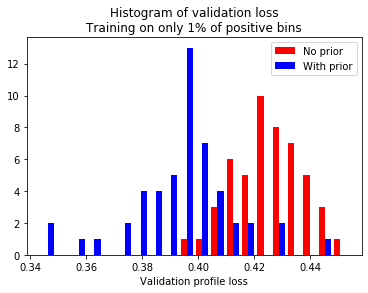

In [55]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation loss"
title += "\nTraining on only 1% of positive bins"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [36]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

-4.2640587687389155
5.566017270666034e-05
